In [26]:
import glob

import matplotlib.pyplot as plt
import xarray as xr
import xclim as xc

In [2]:
print(xc.__version__)

0.56.0


### Read and prepare input data

In [3]:
def convert_units(da, target_units):
    """Convert units.

    Parameters
    ----------
    da : xarray DataArray
        Input array containing a units attribute
    target_units : str
        Units to convert to

    Returns
    -------
    da : xarray DataArray
       Array with converted units
    """

    xclim_unit_check = {
        'degrees_Celsius': 'degC',
        'deg_k': 'degK',
    }

    if da.attrs["units"] in xclim_unit_check:
        da.attrs["units"] = xclim_unit_check[da.units]

    try:
        with xr.set_options(keep_attrs=True):
            da = xc.units.convert_units_to(da, target_units)
    except Exception as e:
        if (da.attrs['units'] == 'kg m-2 s-1') and (target_units in ['mm d-1', 'mm day-1']):
            da = da * 86400
            da.attrs["units"] = target_units
        elif (da.attrs['units'] == 'MJ m^-2') and target_units == 'W m-2':
            da = da * (1e6 / 86400)
            da.attrs["units"] = target_units
        else:
            raise e
    
    if target_units == 'degC':
        da.attrs['units'] = 'degC'

    return da

In [4]:
def select_point(ds):
    """Select grid point nearest to Kinglake, Victoria"""
    
    ds = ds.sel({'lat': -37.53, 'lon': 145.34}, method='nearest')
    vars_to_drop = [
        'sigma',
        'level_height',
        'height',
        'crs',
    ]
    for variable in vars_to_drop:
        try:
            ds = ds.drop_vars(variable)
        except ValueError:
            pass
    
    attrs_to_del = ['cell_methods', 'grid_mapping']
    variables = list(ds.keys())
    for variable in variables:
        for attr in attrs_to_del:
            try:
                del ds[variable].attrs[attr]
            except KeyError:
                pass
        
    return ds

In [5]:
pr_files = sorted(glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/latest/*.nc'))

In [6]:
ds_pr_daily = xr.open_mfdataset(pr_files, preprocess=select_point)
ds_pr_daily = ds_pr_daily.sel(time=slice('1980-01-01', '2023-12-31'))
da_pr_daily = convert_units(ds_pr_daily['pr'], 'mm/day')
da_pr_daily = da_pr_daily.compute()

In [7]:
da_pr_annual = da_pr_daily.groupby('time.year').sum('time', keep_attrs=True)
da_pr_annual_mean = da_pr_annual.mean('year', keep_attrs=True)
da_pr_annual_mean.attrs['units'] = 'mm/year'
da_pr_annual_mean = da_pr_annual_mean.compute()

In [8]:
tasmax_files = sorted(glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmax/latest/*.nc'))

In [9]:
ds_tasmax_daily = xr.open_mfdataset(tasmax_files, preprocess=select_point)
ds_tasmax_daily = ds_tasmax_daily.sel(time=slice('1980-01-01', '2023-12-31'))
da_tasmax_daily = convert_units(ds_tasmax_daily['tasmax'], 'degC')
da_tasmax_daily = da_tasmax_daily.compute()

In [10]:
hurs_files = sorted(glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/hurs/latest/*.nc'))

In [11]:
ds_hurs_daily = xr.open_mfdataset(hurs_files, preprocess=select_point)
da_hurs_daily = ds_hurs_daily['hurs'].sel(time=slice('1980-01-01', '2023-12-31'))
da_hurs_daily = da_hurs_daily.compute()

In [12]:
sfcWind_files = sorted(glob.glob('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/sfcWind/latest/*.nc'))

In [13]:
ds_sfcWind_daily = xr.open_mfdataset(sfcWind_files, preprocess=select_point)
da_sfcWind_daily = ds_sfcWind_daily['sfcWind'].sel(time=slice('1980-01-01', '2023-12-31'))
da_sfcWind_daily = da_sfcWind_daily.compute()

### Calculate the FFDI

For the grid point closest to Kinglake in the BARRA-R2 dataset.

In [19]:
da_kbdi_daily = xc.indices.keetch_byram_drought_index(
    da_pr_daily,
    da_tasmax_daily,
    da_pr_annual_mean
)

In [15]:
da_df_daily = xc.indices.griffiths_drought_factor(
    da_pr_daily,
    da_kbdi_daily
)

In [16]:
da_ffdi_daily = xc.indices.mcarthur_forest_fire_danger_index(
    da_df_daily,
    da_tasmax_daily,
    da_hurs_daily,
    da_sfcWind_daily
)

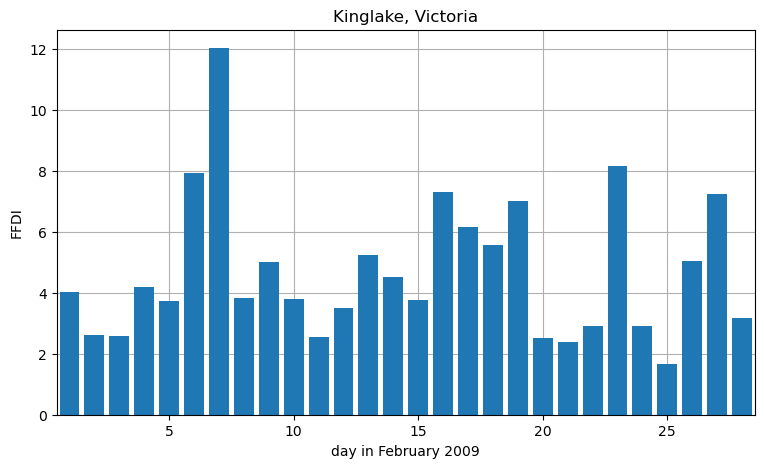

In [33]:
da_ffdi_daily_feb2009 = da_ffdi_daily.sel(time=slice('2009-02-01', '2009-02-28'))

fig, ax = plt.subplots(figsize=[9, 5])
values = da_ffdi_daily_feb2009.values
day_of_month = da_ffdi_daily_feb2009['time'].dt.day.values
plt.bar(day_of_month, values, zorder=2)
plt.xlim(day_of_month[0] - 0.5, day_of_month[-1] + 0.5)
plt.title('Kinglake, Victoria')
plt.ylabel('FFDI')
plt.xlabel('day in February 2009')
plt.grid()
plt.show()

These FFDI values are relatively low given that the daily mean relative humidity and surface wind speed was used in this quick example, but as a sanity check they peak on Black Saturday (7 February 2009) which makes sense.